# Определение FraudScore депозита
Фиатной команде нужен AntiFraudService для получения fraudScore текущего депозита <br>для дальнейшего принятия решения об Capture или его отклонении. <br>Это поможет нам уменьшить Fraud/sell ratio.

**Некоторые показатели, указывающие на мошенников**
- Несоответствие локации
- Крупные суммы транзакций
- Частые транзакции
- Изменение типа транзакций
- Подозрительные места совершения платежей
- Необычные временные рамки
- Повторяющиеся транзакции
- Несколько неудачных попыток авторизации
- Использование заблокированных карт
<br>Важно помнить, что каждый индивидуальный показатель не обязательно указывает <br>на мошенничество - обычно это сочетание нескольких факторов вызывает тревогу.


**Описание данных тестового набора данных**
- "Kyc_citizenship" - страна выдачи документа в kyc в формате ISO2;
- "Deposit_amount_cat" - категория сумма депозита в USD. <br>(≥0 до 100 - 1я категория. ≥100 до 500 - 2я, ≥500 до 2000 - 3я, ≥2000 - 4я);
- "Deposit_user_time_diff_cat" - категория разницы в днях между совершенным депозитом <br>и созданием пользователя (≥0 до 3 - 1я категория, ≥3 до 10 - 2я, ≥10 до 30 - 3я, ≥30 - 4я);
- "Deposit_kyc_time_diff_cat" - категория разницы в днях между совершенным депозитом и <br>прохождением пользователем kyc (<0 - 0я категория, ≥0 до 3 - 1я, ≥3 до 10 - 2я, ≥10 до 30 - 3я, ≥30 - 4я);
- "Deposit_card_country" - страна выпуска карты в формате ISO2;
- "Deposit_ip_country" - ip адрес с которого совершен депозит в формате ISO2;
- "Deposit_language" - выбранный язык на устройстве (en, ru … );
- "deposit_fraud" - целевой параметр. <br>Принимает значение true если deposit_fraud=true или deposit_disputed=true.

**Ход исследования**
- Знакомство с данными
- Предобработка данных (при необходимости)
- Определение скора `baseline` модели
- Тренировка других моделей
- Выбор лучшей модели
- Проверка модели на тестовой выборке
- Определение важности признаков
- Заключение

**Целевая метрика**
<br>ROC-AUC (Receiver Operating Characteristic - Area Under the Curve) является метрикой, 
<br>которая оценивает качество бинарной классификации, учитывая полноту (True Positive Rate) 
<br>и специфичность (True Negative Rate) модели. 
<br>ROC-AUC измеряет способность модели различать между классами и представляет площадь под кривой ROC. 
<br>ROC-AUC особенно полезна, когда важно контролировать баланс между ложно-положительными и 
<br>ложно-отрицательными предсказаниями. <br>Она также устойчива к несбалансированным классам.

## Импорт библиотек

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import phik

from phik.report import plot_correlation_matrix
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

warnings.filterwarnings("ignore", category=UserWarning)

# from sklearn.metrics import f1_score
# import numpy as np

## EDA

### Тренировочный набор данных

In [2]:
df_exm = pd.read_excel('data/Data set.xlsx')
df_exm.info()
df_exm.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4115 entries, 0 to 4114
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   user_id                     4115 non-null   object
 1   kyc_citizenship             4051 non-null   object
 2   deposit_amount_cat          4115 non-null   int64 
 3   deposit_user_time_diff_cat  4115 non-null   int64 
 4   deposit_kyc_time_diff_cat   4115 non-null   int64 
 5   deposit_card_country        4037 non-null   object
 6   deposit_ip_country          4049 non-null   object
 7   deposit_language            4115 non-null   object
 8   deposit_fraud               4115 non-null   bool  
dtypes: bool(1), int64(3), object(5)
memory usage: 261.3+ KB


,user_id,kyc_citizenship,deposit_amount_cat,deposit_user_time_diff_cat,deposit_kyc_time_diff_cat,deposit_card_country,deposit_ip_country,deposit_language,deposit_fraud
1639,627ee30b-0d35-4e25-899e-6ed18126c528,PT,2,3,1,GB,GB,en,False
1300,4bcb20f1-0ccd-4c39-ae0d-e2e6881dd833,FR,2,4,4,FR,FR,fr,False
4002,f410cf1e-fb2e-4f66-a428-01cf4ed89001,GB,3,4,4,GB,GB,en,False
2554,a22da6ad-7228-4621-8187-51ae290243db,TR,2,3,2,TR,TR,tr,False
1008,3ae3e6dc-3491-428e-9702-de68300c9756,MY,3,2,2,MY,MY,en,True


In [7]:
print(f"количество полных дубликатов строк: {df_exm.duplicated().sum()}")

количество полных дубликатов строк: 0


Удаление полных повторов в строках

In [6]:
df_exm = df_exm.drop_duplicates().reset_index(drop=True)

In [12]:
print(f"количество уникальных user_id: {len(set(df_exm['user_id']))}")
print(f"""отношение положительного класса целевого признака к отрицательному: 
    {round(df_exm['deposit_fraud'].value_counts()[1] / 
           df_exm['deposit_fraud'].value_counts()[0], 
           2)}""")
df_exm.info()

количество уникальных user_id: 1445
отношение положительного класса целевого признака к отрицательному: 
    0.06
<class 'pandas.core.frame.DataFrame'>
Index: 2288 entries, 0 to 2324
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   user_id                     2288 non-null   object
 1   kyc_citizenship             2288 non-null   object
 2   deposit_amount_cat          2288 non-null   int64 
 3   deposit_user_time_diff_cat  2288 non-null   int64 
 4   deposit_kyc_time_diff_cat   2288 non-null   int64 
 5   deposit_card_country        2288 non-null   object
 6   deposit_ip_country          2288 non-null   object
 7   deposit_language            2288 non-null   object
 8   deposit_fraud               2288 non-null   bool  
dtypes: bool(1), int64(3), object(5)
memory usage: 163.1+ KB


Удаление пропущенных значений

In [11]:
df_exm = df_exm.dropna()

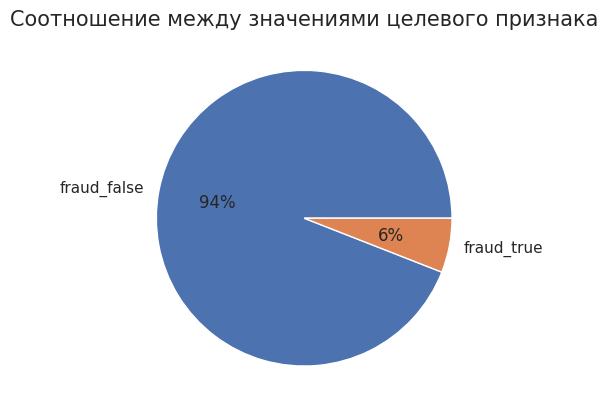

In [88]:
labels = 'fraud_false', 'fraud_true'
sizes = [df_exm['deposit_fraud'].value_counts()[0], df_exm['deposit_fraud'].value_counts()[1]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.0f%%')
plt.title('Соотношение между значениями целевого признака', size=15)
plt.show()

Анализ корреляции между признаками

interval columns not set, guessing: ['deposit_amount_cat', 'deposit_user_time_diff_cat', 'deposit_kyc_time_diff_cat']


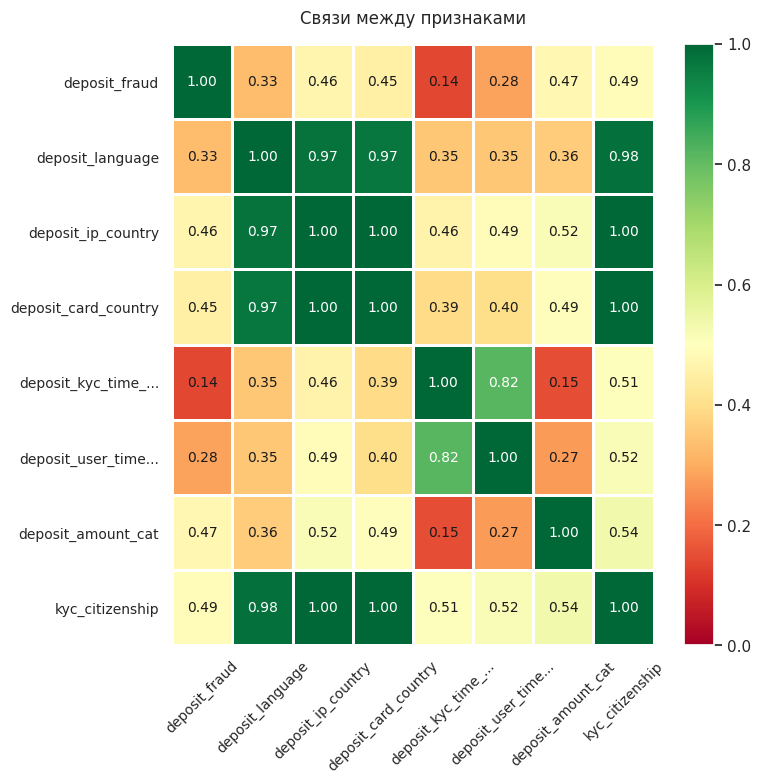

In [14]:
phik_overview = df_exm.drop(columns=['user_id']).phik_matrix()

sns.set()
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1,
                        fontsize_factor=1.0, figsize=(8, 8))
plt.xticks(rotation=45)
plt.title('Связи между признаками', fontsize=12, y=1.02)
plt.tight_layout()

Выводы:
- данные очищены от полных дубликатов строк
- удалены строки с пропусками (они могли повлиять на обучение)
- соотношение классов в целевом признаке - 0.06
- прямой зависимости между целевым признаком и другими не наблюдается

### Полный набор данных

In [ ]:
df_full = pd.read_csv('data/DataSet_full.csv')
df_full.info()
df_full.sample(5)

## Data preparation

Фиксация констант

In [75]:
RS = 42
cat_features = ['kyc_citizenship', 
                'deposit_card_country', 
                'deposit_ip_country', 
                'deposit_language']

### Тренировочный набор данных

Выделение целевого признака

In [17]:
X_base = df_exm.drop(['deposit_fraud'], axis=1)
y_base = df_exm['deposit_fraud']
X_base.shape, y_base.shape

((2288, 8), (2288,))

Использование техник кодирования и масштабирования, <br>чтобы привести данные к виду, подходящему для обучения линейной модели

In [76]:
def data_encoding(X_data):
    '''
    - на вход принимает датасет признаков без целевого
    - производит кодирование нечисловых категориальных признаков
    - производит масшатбирование всех числовых признаков
    - возвращает новый датасет
    '''
    encoder = OrdinalEncoder()
    X_data_oe = (pd.DataFrame(
        encoder.fit_transform(X_data[cat_features]), 
        columns=cat_features, 
        index=X_data.index)
                )
    X_data_oe = (X_data.drop(cat_features, axis=1)
                 .merge(X_data_oe, 
                        how='left', 
                        left_index=True, 
                        right_index=True, 
                        sort=False)
                )
        
    scaler = StandardScaler()
    X_data_es = (pd.DataFrame(
        scaler.fit_transform(X_data_oe.drop(['user_id'], axis=1)), 
        columns=X_data_oe.drop(['user_id'], axis=1).columns, 
        index=X_data_oe.index)
                )
    
    return X_data_es

In [77]:
X_base_es = data_encoding(X_base)
X_base_es.shape

(2288, 7)

Разделение на обучающую и тестовую выборки

In [79]:
X_base_train, X_base_test, y_base_train, y_base_test = (
    train_test_split(X_base_es, 
                     y_base, 
                     test_size=0.2, 
                     random_state=RS, 
                     stratify=y_base)
)
X_base_train.shape, X_base_test.shape, y_base_train.shape, y_base_test.shape

((1830, 7), (458, 7), (1830,), (458,))

## Modeling

### Baseline (Logistic Regression)

ROC-AUC на тестовой выборке: 0.79


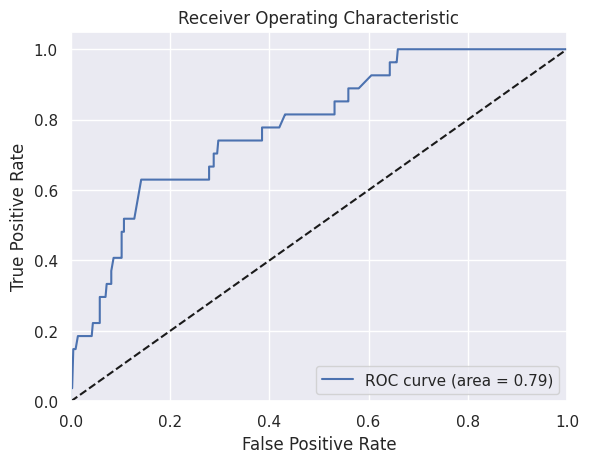

In [87]:
baseline = LogisticRegression(random_state=RS, max_iter=1000)
baseline.fit(X_base_train.values, y_base_train)

# Вычисление ROC-AUC
y_pred_base = baseline.predict_proba(X_base_test.values)[:, 1]
roc_auc_baseline = roc_auc_score(y_base_test, y_pred_base)
print(f"ROC-AUC на тестовой выборке: {round(roc_auc_baseline, 2)}")

# Визуализация кривой ROC
fpr_lg, tpr_lg, thresholds_lg = roc_curve(y_base_test, y_pred_base)
plt.plot(fpr_lg, tpr_lg, label='ROC curve (area = %0.2f)' % roc_auc_baseline)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()